In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf


In [191]:
df = pd.read_csv('cleaned_data.csv')
df["title_year"] = df["title_year"].astype(int)

In [192]:
#most coorelated with gross
df.corr()["gross"].sort_values(ascending=False)

gross                        1.000000
num_voted_users              0.641477
num_user_for_reviews         0.551155
num_critic_for_reviews       0.476112
movie_facebook_likes         0.372837
actor_3_facebook_likes       0.288565
actor_2_facebook_likes       0.267771
cast_total_facebook_likes    0.266763
imdb_score                   0.236789
duration                     0.214021
profit                       0.201270
actor_1_facebook_likes       0.173135
adventure                    0.159315
director_facebook_likes      0.122583
family                       0.097315
animation                    0.092961
budget                       0.089921
fantasy                      0.087722
action                       0.083584
title_year                   0.078680
sci_fi                       0.076707
aspect_ratio                 0.060769
musical                      0.001973
western                     -0.012913
sport                       -0.019128
war                         -0.023657
mystery     

## Which Genre Is More Profitable?

In [193]:
# #organize data to plot avg yearly profit for each genre
# df['profit'] = df['gross'] - df['budget']
# df['year'] = df['title_year'].astype(int)

# #subset data to only include movies from 2000-latest year
# df = df[df['year'] >= 2008]
# #subsect data to only include movies from 2000-latest year
# #group by genre and year and find the average profit for each genre
# df = df.groupby(['genres', 'year']).mean()
# df = df.reset_index()
# df = df[['genres', 'year', 'gross']]
# df = df.sort_values(by=['year', 'gross'], ascending=False)
# df = df.groupby('genres').head(5)
# print(df)






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


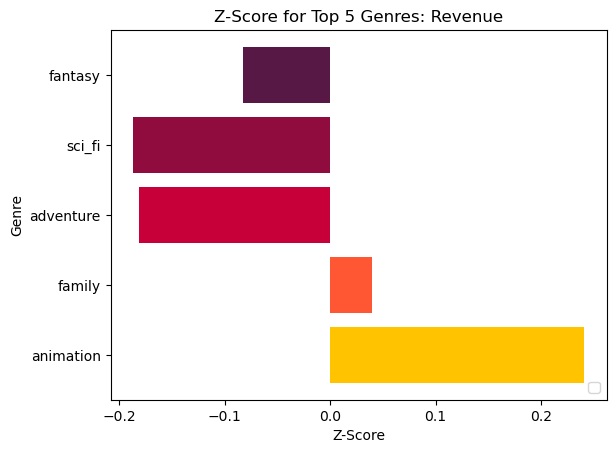

In [194]:
df_rev = df.copy()
# Define top 5 genres
top_5 = ['animation', 'family', 'adventure', 'sci_fi', 'fantasy']

# Drop irrelevant columns
df_rev = df_rev.drop(columns=['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western'])

# Format year column
df_rev['title_year'] = df_rev['title_year'].astype(str).str.extract('(\d{4})', expand=False).astype(float)

# Filter by top 5 genres
df_rev = df_rev[top_5 + ['title_year', 'gross']]
df_rev = pd.melt(df, id_vars=['title_year', 'gross'], value_vars=top_5, var_name='genre', value_name='dummy_value')
df_rev = df_rev[df_rev['dummy_value'] == 1]
df_rev = df_rev.drop(columns=['dummy_value'])

# Calculate z-score for gross profit
df_rev['z_score'] = (df_rev['gross'] - df_rev['gross'].mean()) / df_rev['gross'].std()

# Group by year and genre and calculate mean z-score
grouped = df_rev.groupby(['title_year', 'genre']).agg({'z_score': np.mean}).reset_index()

# Condense each of the 5 genres into 1 horizontal bar, use nice colors
for i, genre in enumerate(top_5):
    genre_df = grouped[grouped['genre'] == genre]
    plt.barh(y=i, width=genre_df['z_score'].mean(), color=['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845'][i])   

# Set plot properties
plt.yticks(range(len(top_5)), top_5)
plt.title('Z-Score for Top 5 Genres: Revenue')
plt.xlabel('Z-Score')
plt.ylabel('Genre')
plt.legend(loc='lower right')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


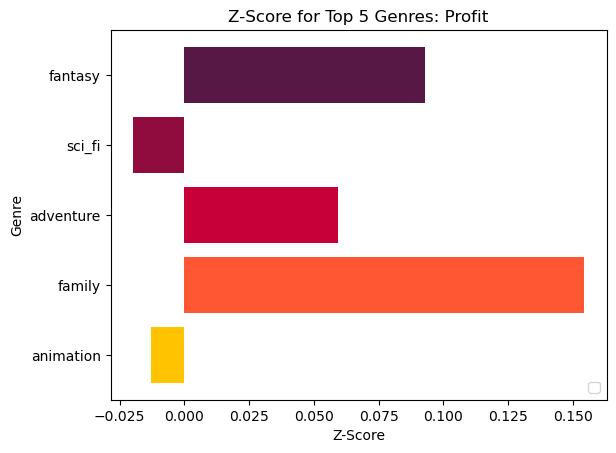

In [195]:
#Do same for profit
df_prof = df.copy()
# Define top 5 genres
top_5 = ['animation', 'family', 'adventure', 'sci_fi', 'fantasy']

# Drop irrelevant columns
df_prof = df_prof.drop(columns=['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western'])

# Format year column
df_prof['title_year'] = df_prof['title_year'].astype(int)

# Filter by top 5 genres
df_prof = df_prof[top_5 + ['title_year', 'profit']]
df_prof = pd.melt(df, id_vars=['title_year', 'profit'], value_vars=top_5, var_name='genre', value_name='dummy_value')
df_prof = df_prof[df_prof['dummy_value'] == 1]
df_prof = df_prof.drop(columns=['dummy_value'])

# Calculate z-score for gross profit
df_prof['z_score'] = (df_prof['profit'] - df_prof['profit'].mean()) / df_prof['profit'].std()

# Group by year and genre and calculate mean z-score
grouped = df_prof.groupby(['title_year', 'genre']).agg({'z_score': np.mean}).reset_index()

# Condense each of the 5 genres into 1 horizontal bar, use nice colors
for i, genre in enumerate(top_5):
    genre_df = grouped[grouped['genre'] == genre]
    plt.barh(y=i, width=genre_df['z_score'].mean(), color=['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845'][i])

# Set plot properties   
plt.yticks(range(len(top_5)), top_5)
plt.title('Z-Score for Top 5 Genres: Profit')
plt.xlabel('Z-Score')
plt.ylabel('Genre')
plt.legend(loc='lower right')
plt.show()




In [196]:
df.head(1)

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,horror,music,musical,mystery,romance,sci_fi,sport,thriller,war,western
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,action,CCH Pounder,...,0,0,0,0,0,0,0,0,0,0


In [197]:
# Define the formula for the linear regression model
formula = 'gross ~ animation + family + adventure + sci_fi + fantasy'

# Fit the linear regression model
model = smf.ols(formula=formula, data=df).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     164.9
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          1.01e-169
Time:                        14:41:18   Log-Likelihood:            -2.1926e+05
No. Observations:               11237   AIC:                         4.385e+05
Df Residuals:                   11231   BIC:                         4.386e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.744e+07   7.68e+05     61.789      0.0

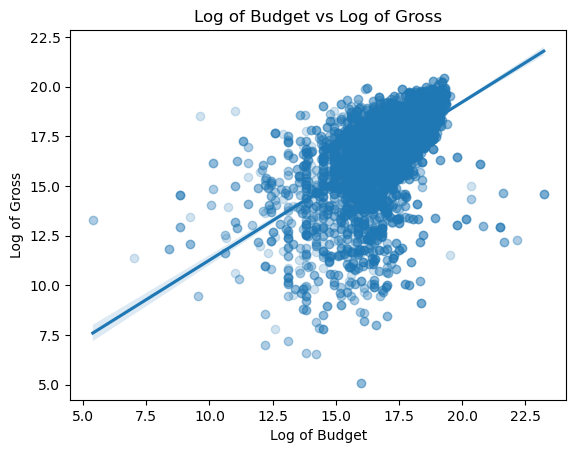

In [198]:
#scatter plot of log of budget vs log  of gross
#add trendline
sns.regplot(x=np.log(df['budget']), y=np.log(df['gross']), data=df, scatter_kws={'alpha':0.2})
plt.title('Log of Budget vs Log of Gross')
plt.xlabel('Log of Budget')
plt.ylabel('Log of Gross')
plt.show()


In [199]:
#get corr of plot above
df.corr()['budget']['gross']

0.08992122598153858

## Classification by Logistic Regression

<AxesSubplot:>

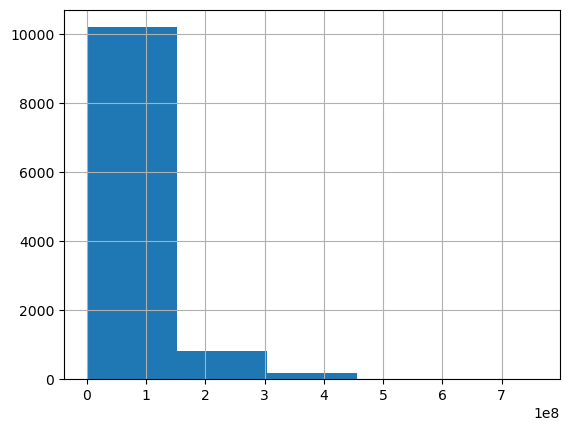

In [200]:
#As a second model, we also tried classification by standard L1-regularized logistic regression. We chose this method because it generated a multi-class model with linear weights, most directly comparable to the feature weights given by linear regression. To define our classes, we drew a histogram of movie revenues to create 5 different buckets for prediction as shown in Table 4. The first bucket includes the lowest 20% of the gross distribution and the last bucket includes the highest 20%.

#create histofram of movie profit 5 buckets
df['gross'].hist(bins=5)



In [201]:
import statsmodels.api as sm


In [202]:
#make column in data for 5 bins of gross
df['gross_bins'] = pd.cut(df['gross'], bins=5, labels=['1', '2', '3', '4', '5'])
#make gross_bins an int
df['gross_bins'] = df['gross_bins'].astype(int)
#make logistic regression model with gross revenue as dependent variable
#and all other variables as independent variables

#drop gross revenue column
df = df.drop(columns=['gross'])



In [203]:
#make train test from df to predict gross revenue
X = df.drop(columns=['gross_bins'])
y = df['gross_bins']
#make train csv and test csv only 2!
train = df.sample(frac=0.8, random_state=1)
test = df.loc[~df.index.isin(train.index)]


In [204]:
#formuka
formula = 'gross_bins ~ animation + family + adventure + sci_fi + fantasy'

#fit model
model = smf.glm(formula=formula, data=train, family=sm.families.Binomial()).fit()

#print model summary
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             gross_bins   No. Observations:                 8990
Model:                            GLM   Df Residuals:                     8984
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 02 Mar 2023   Deviance:                       76746.
Time:                        14:41:20   Pearson chi2:                 6.82e+18
No. Iterations:                     5   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.197e+14      8e+05      4e+08      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning: invalid value encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1015: RuntimeWarning: invalid value encountered in log
  n * np.log(1 - mu + 1e-20)) * var_weights


In [213]:
#manually find TP,TN,FP,FN and plot grid displaying results
#from model

#make predictions on test
predictions = model.predict(test)

#fina accuracy and recall of logistic model. ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
print('Accuracy: ', accuracy_score(test['gross_bins'], predictions))
print('Recall: ', recall_score(test['gross_bins'], predictions, average='macro'))
print('Precision: ', precision_score(test['gross_bins'], predictions, average='macro'))
print('Confusion Matrix: ', confusion_matrix(test['gross_bins'], predictions))




Accuracy:  0.9069870939029817
Recall:  0.2
Precision:  0.18139741878059634
Confusion Matrix:  [[2038    0    0    0    0]
 [ 161    0    0    0    0]
 [  41    0    0    0    0]
 [   1    0    0    0    0]
 [   6    0    0    0    0]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
accuracy

0.9069870939029817